In [1]:
import numpy as np
import tensorflow as tf

print(tf.__version__)

#config = tf.ConfigProto(intra_op_parallelism_threads=3, inter_op_parallelism_threads=3, \
#                        allow_soft_placement=True, device_count = {'CPU': 1})
#session = tf.Session(config=config)
session = tf.InteractiveSession()


1.2.0-rc2


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

trainX = mnist.train.images
trainY = mnist.train.labels

testX = mnist.test.images
testY = mnist.test.labels

print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)


Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
(55000, 784)
(55000, 10)
(10000, 784)
(10000, 10)


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_img(sample):
    pixels = np.array(sample, dtype = 'float32')
    pixels = pixels.reshape((28,28))
    #
    plt.imshow(pixels)
    plt.show()
    

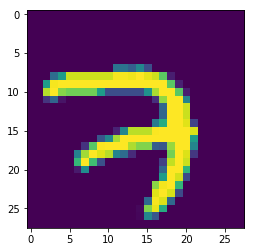

[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


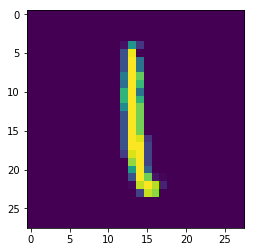

[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]


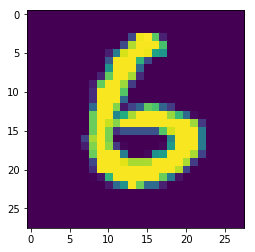

[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]


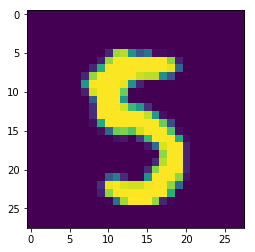

[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]


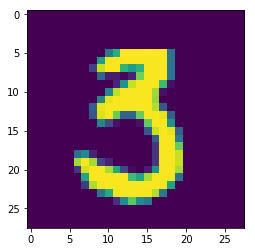

[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]


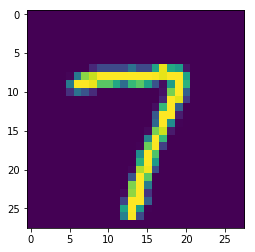

[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


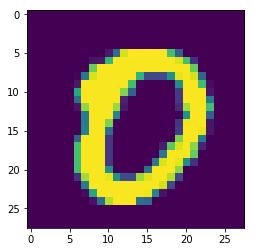

[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


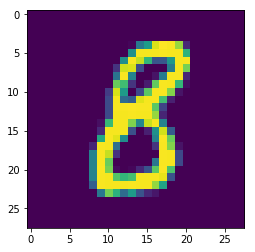

[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


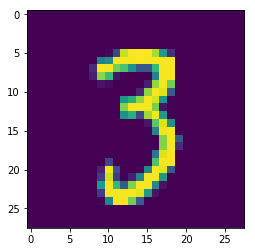

[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]


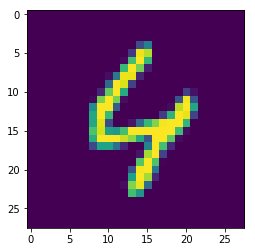

[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]


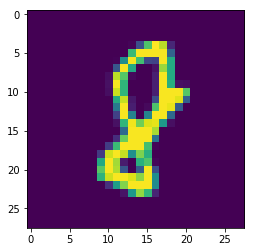

[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


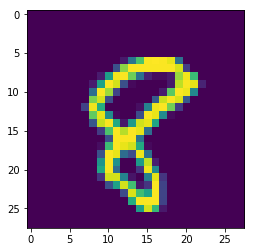

[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


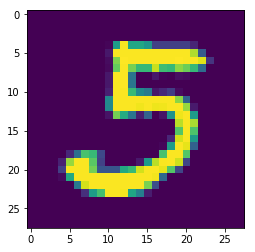

[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]


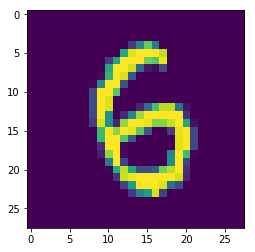

[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]


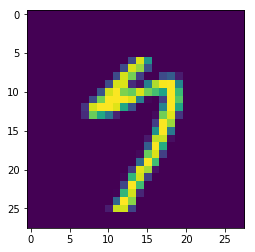

[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


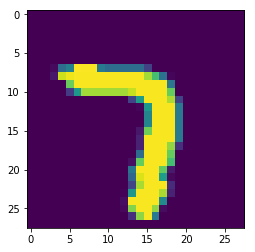

[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


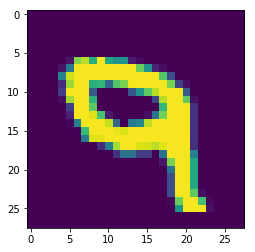

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]


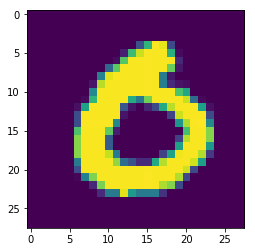

[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


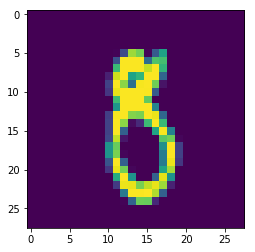

[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


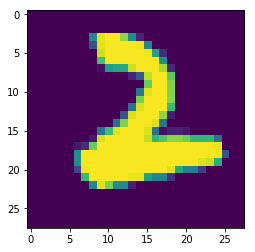

[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]


In [4]:
for i in range(20):
    show_img(trainX[i*20, :])
    print (trainY[i*20])

In [5]:
example_num, input_num = trainX.shape
output_num = len(trainY[0,:])
print(example_num, input_num, output_num)

55000 784 10


In [46]:
def cross_entropy(predictions, targets, epsilon=1e-12):
    ce = -tf.reduce_mean(tf.log(tf.reduce_sum(y * tf.exp(y_pred), reduction_indices=[1]) / tf.reduce_sum(tf.exp(y_pred))))
    return ce

In [238]:
'''
current network has 1 hidden layer activated by sigmoid function and output layer. 
Thus we should optimise two matrices of weights and two vectors of biases - for hidden and output layers.
'''

#number of hidden layers
num_hidden_nodes = 100 #400 - 0.979


# creating weights and bias for hidden layer
W1_initial = np.random.rand(input_num, num_hidden_nodes)/(input_num*num_hidden_nodes) # make noise and norm it
W1_b = tf.Variable((np.random.rand(1, num_hidden_nodes)), dtype=tf.float32, name='W1_b') #  same fir bias
W1 = tf.Variable(W1_initial, dtype=tf.float32, name='W1') # make tf variable with initial value if W_initial

# creating weights and bias for output layer
W2_initial = np.random.rand(num_hidden_nodes, output_num)/(num_hidden_nodes*output_num) # make noise and norm it
W2_b = tf.Variable((np.random.rand(1, output_num)), dtype=tf.float32, name='W2_b') #  same fir bias
W2 = tf.Variable(W2_initial, dtype=tf.float32, name='W2') # make tf variable with initial value if W_initial


# placeholders for (x, y)
x = tf.placeholder(tf.float32, shape=(None, input_num), name='x') # don't rename it
y = tf.placeholder(tf.float32, shape=(None, output_num), name='y') # don't rename it


# dropout layer to avoid overfitting
h = tf.nn.dropout(h, 0.75)
# sigmoid function for hidden layer.
h = tf.nn.sigmoid(tf.matmul(x, W1) + W1_b)
# dence layer for output
y_pred = tf.matmul(h, W2) + W2_b

# actually it is just a loss function based on cross-entropy
cost = -tf.reduce_mean(
    tf.log(
        tf.reduce_sum(y * tf.exp(y_pred), reduction_indices=[1])
        / tf.reduce_sum(tf.exp(y_pred))
    ))


lr = 0.1 # learning rate
optimizer = tf.train.GradientDescentOptimizer(lr)

grads = tf.gradients(cost, tf.trainable_variables()) # take gradient of ALL TRAINABLES variables
grad_list = list(zip(grads, tf.trainable_variables()))

update = optimizer.apply_gradients(grads_and_vars=grad_list) # don't rename this op

pred = tf.cast(tf.equal(tf.argmax(y_pred,1), tf.argmax(y,1)), tf.float32)
acc = tf.reduce_mean(pred) # don't rename this op


In [239]:
trainX.shape

(55000, 784)

In [240]:
#Train!
# don't use test data here

# we should split the data into mini-batches.
# little batch is better but slower
# big bacth is faster and little bit worse. And limited by your GPU memory
batch_size = 10 # with 55000 objects we will not loose a rest of batch, because 55000 % 100 = 0
epocs = 200 # 1 epoch is view of all elements in dataset 1 time
batch_num = int(example_num/batch_size)

sess = tf.Session()
sess.run(tf.global_variables_initializer()) # it's necessary

for epoch in range(epocs):
    err = 0
    for batch in range(batch_num):
        # extract a batch
        batch_x = trainX[batch*batch_size : batch*batch_size + batch_size]
        batch_y = trainY[batch*batch_size : batch*batch_size + batch_size]
        
        # a key operation. Run 'operations' and place data in placeholders 'x' and 'y'
        _, c = sess.run([update, cost], feed_dict={x:batch_x, y:batch_y})
        err += c
    err /= batch_num
    print("epoch: %d error:%f" % (epoch, err))
    
print("optimization done")
acc_train = sess.run([acc], feed_dict={x:trainX, y:trainY})
print('acc:%f'%acc_train[0])


epoch: 0 error:3.097543
epoch: 1 error:2.646605
epoch: 2 error:2.575731
epoch: 3 error:2.539056
epoch: 4 error:2.515263
epoch: 5 error:2.497926
epoch: 6 error:2.484499
epoch: 7 error:2.473691
epoch: 8 error:2.464713
epoch: 9 error:2.457063
epoch: 10 error:2.450417
epoch: 11 error:2.444553
epoch: 12 error:2.439310
epoch: 13 error:2.434574
epoch: 14 error:2.430261
epoch: 15 error:2.426305
epoch: 16 error:2.422656
epoch: 17 error:2.419268
epoch: 18 error:2.416108
epoch: 19 error:2.413148
epoch: 20 error:2.410366
epoch: 21 error:2.407746
epoch: 22 error:2.405272
epoch: 23 error:2.402932
epoch: 24 error:2.400714
epoch: 25 error:2.398608
epoch: 26 error:2.396606
epoch: 27 error:2.394697
epoch: 28 error:2.392876
epoch: 29 error:2.391133
epoch: 30 error:2.389462
epoch: 31 error:2.387857
epoch: 32 error:2.386315
epoch: 33 error:2.384833
epoch: 34 error:2.383407
epoch: 35 error:2.382034
epoch: 36 error:2.380711
epoch: 37 error:2.379433
epoch: 38 error:2.378200
epoch: 39 error:2.377007
epoch: 40 

In [241]:
# Test!
# don't change these line

acc_test = sess.run([acc], feed_dict={x:testX, y:testY})
print('acc:%f'%acc_test[0])

acc:0.973200
